# Imports

In [2]:
import numpy as np
import pandas as pd
from polars import read_csv as pl_read_csv
import polars as pl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from tqdm import tqdm
import matplotlib.lines as mlines
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

plt.style.use('dark_background')
pd.options.mode.chained_assignment = None

In [3]:
def generate_stat(folder, eval_quantiles, agent_name):

    eval_df = pl_read_csv(folder, n_threads=8).to_pandas()
    eval_loop_df = eval_df[['episode', 'step_pnl', 'hed_cost']].groupby('episode').aggregate('sum')
    eval_loop_df.columns = ['episode_return', 'tc']
    
    gamma_exposure_df = eval_df[['episode', 'gamma_before_hedge', 'gamma_after_hedge']]
    gamma_exposure_df['gamma_hedged_amount'] = (gamma_exposure_df['gamma_before_hedge'] - gamma_exposure_df['gamma_after_hedge']) * np.sign(gamma_exposure_df['gamma_before_hedge'])
    gamma_exposure_df['gamma_before_hedge_level'] = gamma_exposure_df['gamma_before_hedge'].abs()
    gamma_exposure_df = gamma_exposure_df.groupby('episode').aggregate('sum')
    gamma_exposure = gamma_exposure_df['gamma_hedged_amount'] / gamma_exposure_df['gamma_before_hedge_level']
    
    vega_exposure_df = eval_df[['episode', 'vega_before_hedge', 'vega_after_hedge']]
    vega_exposure_df['vega_hedged_amount'] = (vega_exposure_df['vega_before_hedge'] - vega_exposure_df['vega_after_hedge']) * np.sign(vega_exposure_df['vega_before_hedge'])
    vega_exposure_df['vega_before_hedge_level'] = vega_exposure_df['vega_before_hedge'].abs()
    vega_exposure_df = vega_exposure_df.groupby('episode').aggregate('sum')
    vega_exposure = vega_exposure_df['vega_hedged_amount'] / vega_exposure_df['vega_before_hedge_level']

    # Calculate BCa Bootstrap Confidence Interval for 'episode_return'
    pnl_data = eval_loop_df['episode_return'].values
    pnl_bootstrap = bs.bootstrap(pnl_data, stat_func=bs_stats.mean, alpha=0.05, num_iterations=10000, num_threads=16)
    pnl_mean = pnl_bootstrap.value
    pnl_half_width = (pnl_bootstrap.upper_bound - pnl_bootstrap.lower_bound) / 2

    # Calculate BCa Bootstrap Confidence Interval for 'tc'
    tc_data = eval_loop_df['tc'].values
    tc_bootstrap = bs.bootstrap( tc_data, stat_func=bs_stats.mean, alpha=0.05, num_iterations=10000, num_threads=16 )
    tc_mean = tc_bootstrap.value
    tc_half_width = (tc_bootstrap.upper_bound - tc_bootstrap.lower_bound) / 2

    stats_str = (
        f"{agent_name:<20} pnl mean: {pnl_mean:<6.2f}(±{pnl_half_width:<4.2f}) | "
        f"std: {eval_loop_df['episode_return'].std():<10.5f} | "
        f"Mean-SD: {eval_loop_df['episode_return'].mean() - 1.645 * eval_loop_df['episode_return'].std():<6.2f} | "
        f"gamma-ratio: {gamma_exposure.mean():5.2f}({gamma_exposure.quantile(0.10):5.2f}/{gamma_exposure.quantile(0.90):5.2f}) | "
        f"vega-ratio: {vega_exposure.mean():5.2f}({vega_exposure.quantile(0.10):5.2f}/{vega_exposure.quantile(0.90):5.2f})"
    )
    
    for q in eval_quantiles:
        stats_str += f"| var{100 * q:.0f}: {eval_loop_df['episode_return'].quantile(1 - q):8.2f} "
    
    for q in eval_quantiles:
        cvar_value = eval_loop_df.loc[
            eval_loop_df['episode_return'] <= eval_loop_df['episode_return'].quantile(1 - q),
            'episode_return'
        ].mean()
        stats_str += f"| cvar{100 * q:.0f}: {cvar_value:8.2f} "
    
    stats_str += f"| E[TC]: {tc_mean:<6.2f}(±{tc_half_width:<4.2f})"
    
    print(stats_str)
    return eval_loop_df['episode_return'].values

# Define quantiles for evaluation
eval_quantiles = [0.95]

---------------------------------------
# Show Batched Experiments

## Spread 0.5% - Mean-Std

Heston Mean-Std 0.5%:0 pnl mean: -4.91 (±0.44) | std: 14.29160   | Mean-SD: -28.42 | gamma-ratio:  0.36( 0.03/ 0.64) | vega-ratio:  0.28( 0.11/ 0.40)| var95:   -28.71 | cvar95:   -40.92 | E[TC]: -3.93 (±0.05)
Heston Mean-Std 0.5%:1 pnl mean: -4.71 (±0.46) | std: 14.89356   | Mean-SD: -29.21 | gamma-ratio:  0.48( 0.08/ 0.74) | vega-ratio:  0.27( 0.08/ 0.47)| var95:   -28.20 | cvar95:   -39.92 | E[TC]: -3.78 (±0.03)
Heston Mean-Std 0.5%:2 pnl mean: -4.62 (±0.41) | std: 13.49318   | Mean-SD: -26.81 | gamma-ratio:  0.42( 0.06/ 0.75) | vega-ratio:  0.32( 0.14/ 0.51)| var95:   -26.27 | cvar95:   -36.82 | E[TC]: -3.97 (±0.04)
Heston Mean-Std 0.5%:3 pnl mean: -5.31 (±0.47) | std: 15.52176   | Mean-SD: -30.85 | gamma-ratio:  0.61( 0.26/ 0.87) | vega-ratio:  0.27( 0.09/ 0.47)| var95:   -30.68 | cvar95:   -43.18 | E[TC]: -4.57 (±0.06)
Heston Mean-Std 0.5%:4 pnl mean: -4.63 (±0.41) | std: 13.54687   | Mean-SD: -26.91 | gamma-ratio:  0.33( 0.01/ 0.68) | vega-ratio:  0.34( 0.18/ 0.47)| var95:   -26.

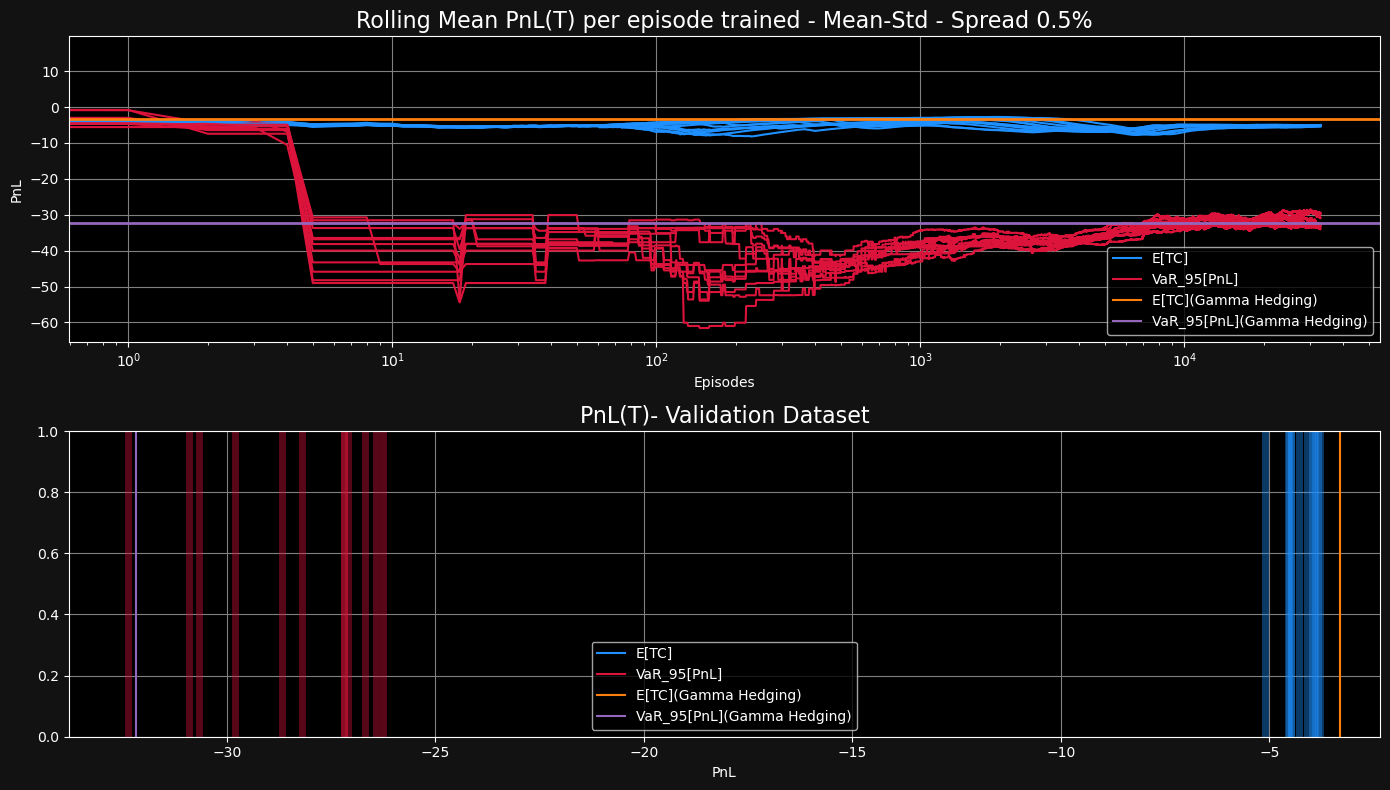

In [4]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_05/Heston_Mean_Std_Batch/'
N_E = 12
batch_template_train = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):    
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()

## Spread 0.5% - VaR

Heston Mean-Std 0.5%:0 pnl mean: -5.67 (±0.46) | std: 14.91112   | Mean-SD: -30.19 | gamma-ratio:  0.72( 0.13/ 1.18) | vega-ratio:  0.29( 0.11/ 0.47)| var95:   -30.87 | cvar95:   -43.61 | E[TC]: -5.30 (±0.08)
Heston Mean-Std 0.5%:1 pnl mean: -3.95 (±0.48) | std: 15.52960   | Mean-SD: -29.49 | gamma-ratio:  0.54( 0.16/ 0.93) | vega-ratio:  0.26( 0.08/ 0.44)| var95:   -28.44 | cvar95:   -42.21 | E[TC]: -4.18 (±0.05)
Heston Mean-Std 0.5%:2 pnl mean: -4.99 (±0.43) | std: 13.96647   | Mean-SD: -27.96 | gamma-ratio:  0.29( 0.01/ 0.60) | vega-ratio:  0.36( 0.18/ 0.51)| var95:   -27.71 | cvar95:   -39.22 | E[TC]: -3.99 (±0.03)
Heston Mean-Std 0.5%:3 pnl mean: -5.22 (±0.43) | std: 14.36010   | Mean-SD: -28.84 | gamma-ratio:  0.38( 0.05/ 0.75) | vega-ratio:  0.35( 0.14/ 0.55)| var95:   -28.38 | cvar95:   -40.79 | E[TC]: -4.37 (±0.04)
Heston Mean-Std 0.5%:4 pnl mean: -4.32 (±0.43) | std: 14.10094   | Mean-SD: -27.51 | gamma-ratio:  0.36( 0.02/ 0.65) | vega-ratio:  0.32( 0.12/ 0.48)| var95:   -27.

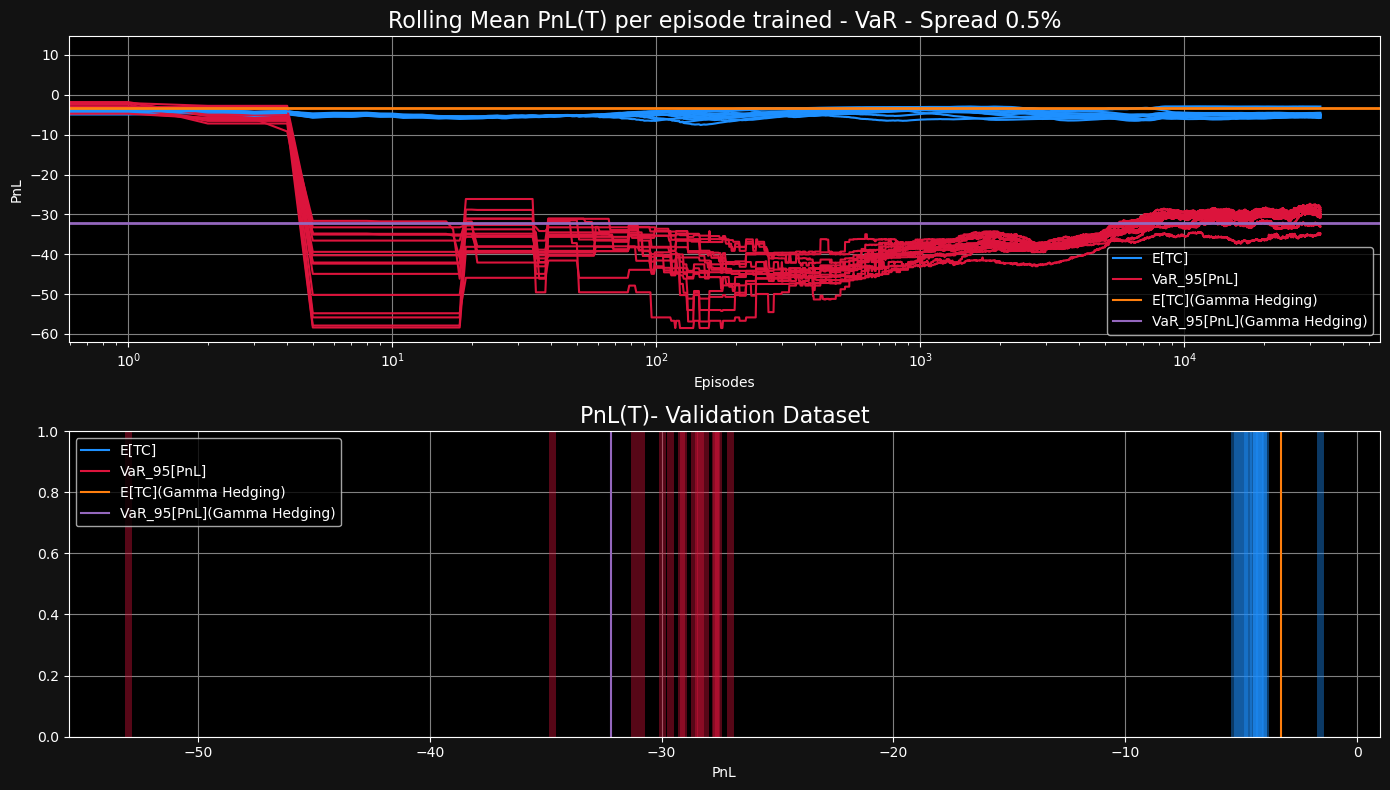

In [5]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_05/Heston_VaR_Batch/'
N_E = 16
batch_template_train = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 0.5% - CVaR

Heston Mean-Std 0.5%:0 pnl mean: -4.83 (±0.45) | std: 14.84064   | Mean-SD: -29.24 | gamma-ratio:  0.40( 0.03/ 0.75) | vega-ratio:  0.37( 0.14/ 0.56)| var95:   -28.82 | cvar95:   -42.19 | E[TC]: -4.35 (±0.04)
Heston Mean-Std 0.5%:1 pnl mean: -4.45 (±0.43) | std: 14.03851   | Mean-SD: -27.54 | gamma-ratio:  0.52( 0.09/ 0.81) | vega-ratio:  0.29( 0.10/ 0.45)| var95:   -27.65 | cvar95:   -39.59 | E[TC]: -4.18 (±0.05)
Heston Mean-Std 0.5%:2 pnl mean: -4.75 (±0.58) | std: 18.60933   | Mean-SD: -35.36 | gamma-ratio:  0.41(-0.03/ 0.83) | vega-ratio:  0.44( 0.12/ 0.73)| var95:   -35.27 | cvar95:   -50.13 | E[TC]: -4.54 (±0.05)
Heston Mean-Std 0.5%:3 pnl mean: -4.89 (±0.44) | std: 14.44489   | Mean-SD: -28.65 | gamma-ratio:  0.37( 0.03/ 0.73) | vega-ratio:  0.35( 0.15/ 0.53)| var95:   -27.61 | cvar95:   -40.62 | E[TC]: -4.27 (±0.03)
Heston Mean-Std 0.5%:4 pnl mean: -5.17 (±0.57) | std: 18.68859   | Mean-SD: -35.92 | gamma-ratio:  0.28(-0.04/ 0.62) | vega-ratio:  0.42( 0.13/ 0.63)| var95:   -35.

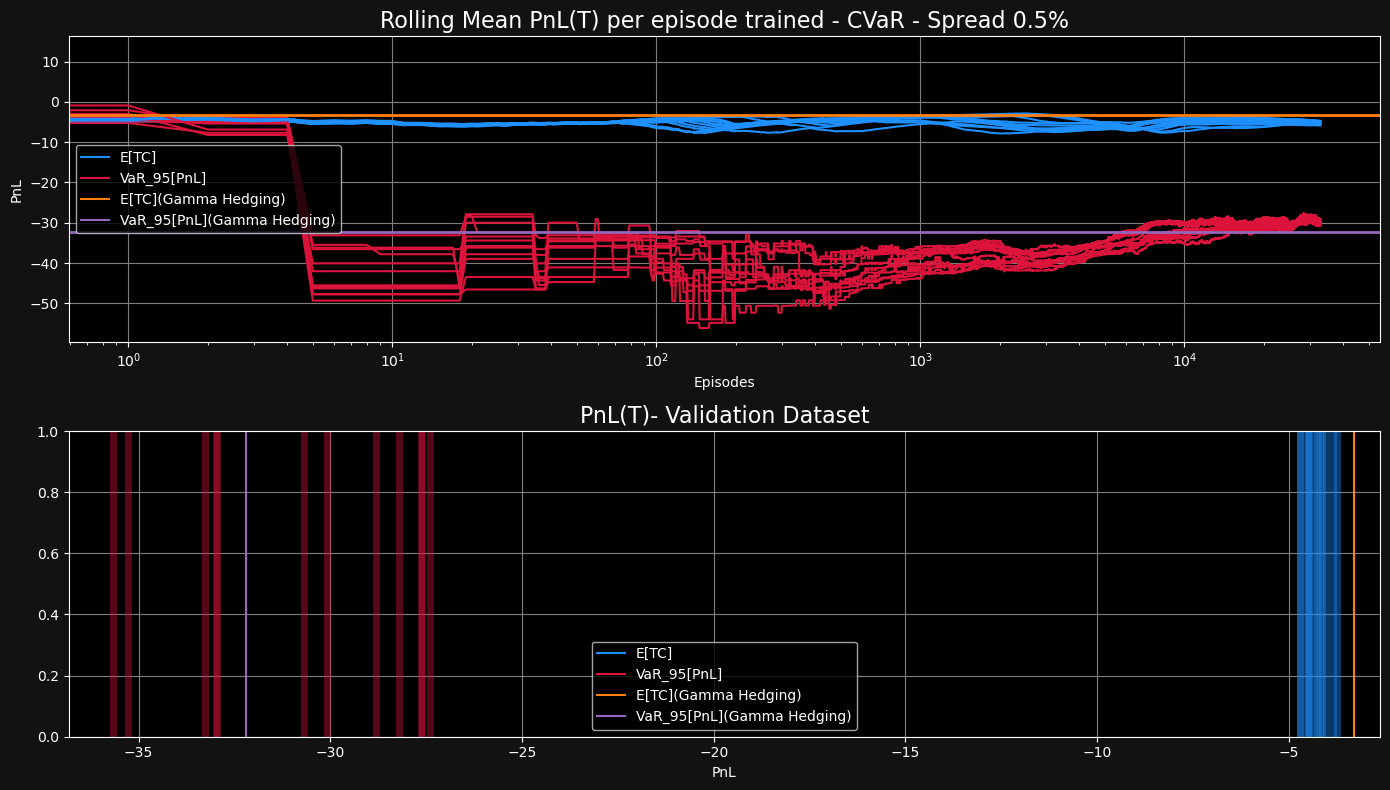

In [6]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_05/Heston_CVaR_Batch/'
N_E = 12
batch_template_train = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 1% - Mean-Std

In [1]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_1/Heston_Mean_Std_Batch/'
N_E = 16
batch_template_train = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(2, N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 1%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_1/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

## Spread 1% - VaR

Heston VaR 0.5%:0    pnl mean: -6.58 (±0.49) | std: 15.98815   | Mean-SD: -32.88 | gamma-ratio:  0.40( 0.02/ 0.92) | vega-ratio:  0.22( 0.07/ 0.38)| var95:   -32.72 | cvar95:   -46.06 | E[TC]: -7.16 (±0.10)
Heston VaR 0.5%:1    pnl mean: -6.30 (±0.52) | std: 16.94980   | Mean-SD: -34.18 | gamma-ratio:  0.66( 0.47/ 0.88) | vega-ratio:  0.16( 0.05/ 0.29)| var95:   -34.42 | cvar95:   -47.25 | E[TC]: -6.41 (±0.09)
Heston VaR 0.5%:2    pnl mean: 0.48  (±1.11) | std: 36.12034   | Mean-SD: -58.94 | gamma-ratio: -0.01(-0.08/ 0.03) | vega-ratio:  0.17( 0.01/ 0.45)| var95:   -53.18 | cvar95:   -73.61 | E[TC]: -3.22 (±0.08)
Heston VaR 0.5%:3    pnl mean: -5.14 (±0.54) | std: 17.77924   | Mean-SD: -34.39 | gamma-ratio:  0.38( 0.02/ 0.65) | vega-ratio:  0.20( 0.07/ 0.32)| var95:   -32.86 | cvar95:   -47.03 | E[TC]: -5.50 (±0.07)
Heston VaR 0.5%:4    pnl mean: 0.48  (±1.10) | std: 36.12034   | Mean-SD: -58.94 | gamma-ratio: -0.01(-0.08/ 0.03) | vega-ratio:  0.17( 0.01/ 0.45)| var95:   -53.18 | cvar9

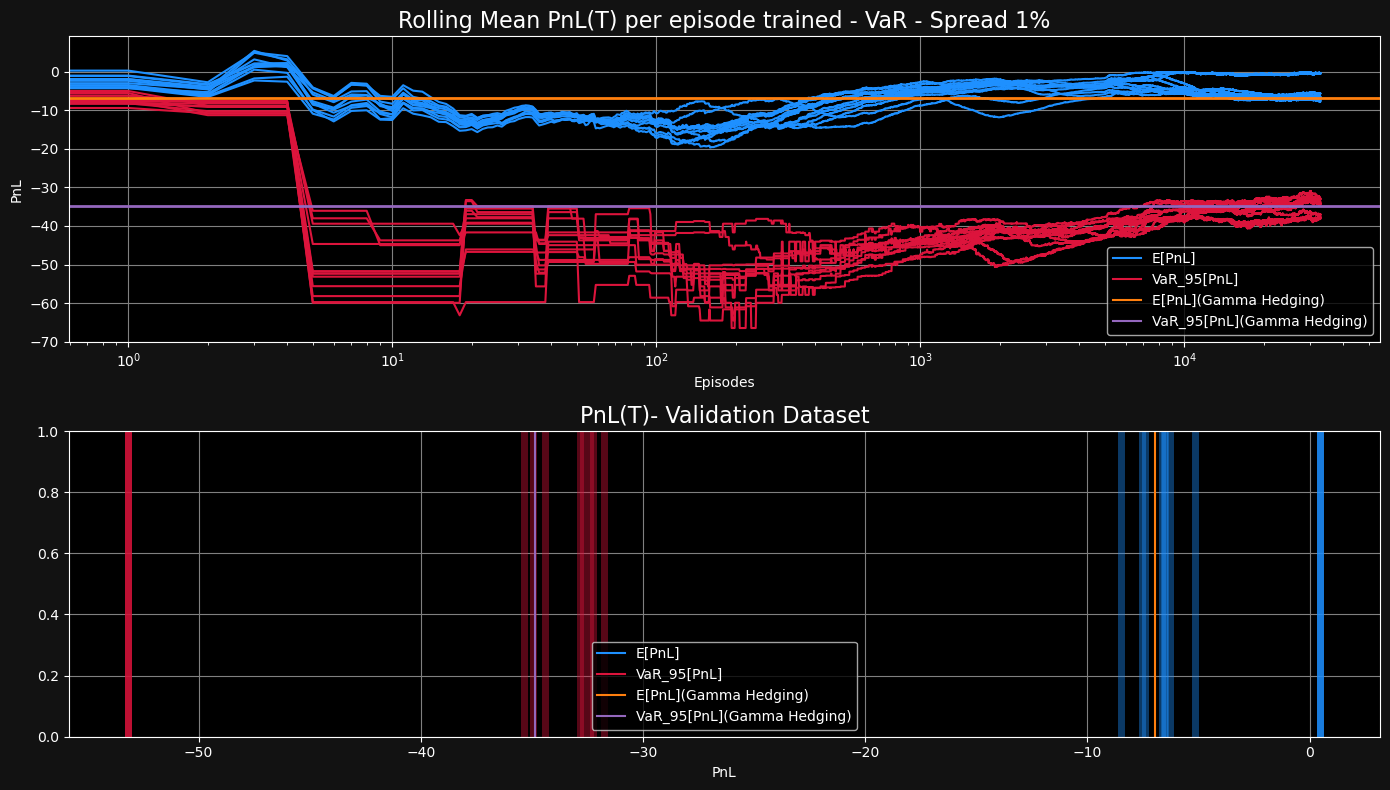

In [ ]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_1/Heston_VaR_Batch/'
N_E = 12
batch_template_train = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 1%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_1/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 1% - CVaR

Heston Mean-Std 0.5%:0 pnl mean: -5.87 (±0.47) | std: 15.44170   | Mean-SD: -31.27 | gamma-ratio:  0.40( 0.09/ 0.61) | vega-ratio:  0.20( 0.08/ 0.31)| var95:   -31.10 | cvar95:   -43.79 | E[TC]: -6.07 (±0.07)
Heston Mean-Std 0.5%:1 pnl mean: -7.59 (±0.48) | std: 15.91589   | Mean-SD: -33.77 | gamma-ratio:  0.63( 0.11/ 1.03) | vega-ratio:  0.21( 0.07/ 0.36)| var95:   -32.83 | cvar95:   -48.19 | E[TC]: -7.85 (±0.13)
Heston Mean-Std 0.5%:2 pnl mean: 0.48  (±1.10) | std: 36.12034   | Mean-SD: -58.94 | gamma-ratio: -0.01(-0.08/ 0.03) | vega-ratio:  0.17( 0.01/ 0.45)| var95:   -53.18 | cvar95:   -73.61 | E[TC]: -3.22 (±0.08)
Heston Mean-Std 0.5%:3 pnl mean: -6.10 (±0.51) | std: 16.40229   | Mean-SD: -33.08 | gamma-ratio:  0.31( 0.01/ 0.57) | vega-ratio:  0.28( 0.09/ 0.40)| var95:   -31.69 | cvar95:   -45.01 | E[TC]: -6.54 (±0.07)
Heston Mean-Std 0.5%:4 pnl mean: 0.48  (±1.11) | std: 36.12034   | Mean-SD: -58.94 | gamma-ratio: -0.01(-0.08/ 0.03) | vega-ratio:  0.17( 0.01/ 0.45)| var95:   -53.

FileNotFoundError: No such file or directory (os error 2): ...amma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv

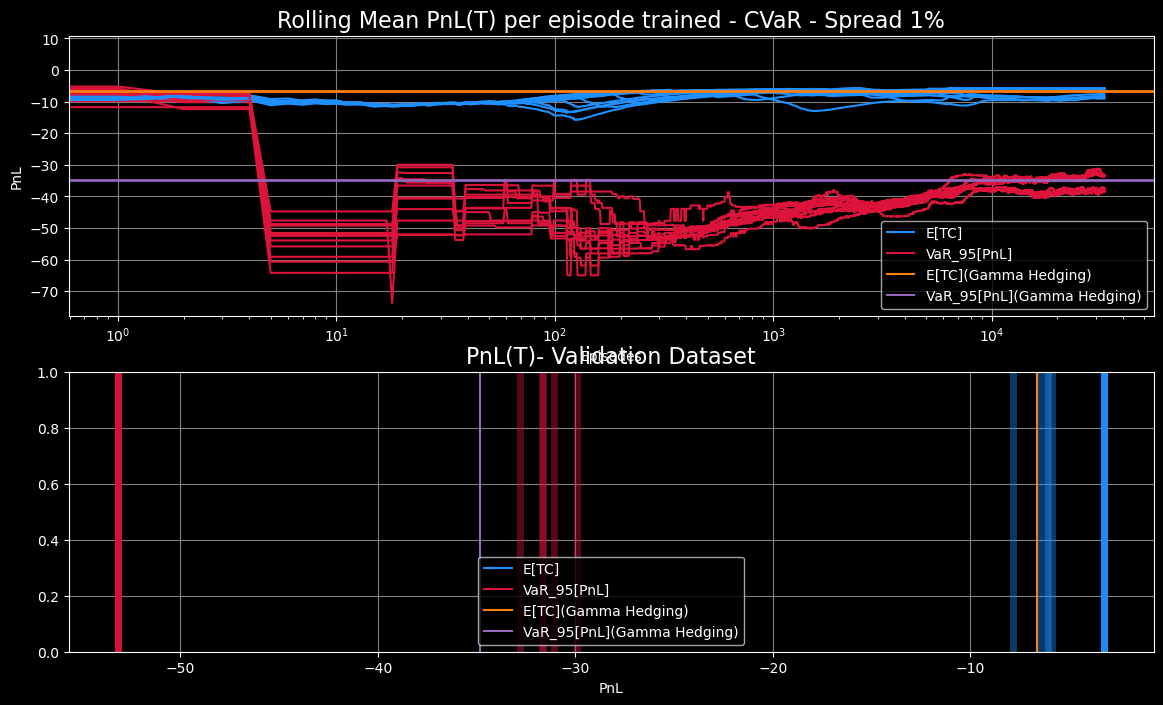

In [ ]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_1/Heston_CVaR_Batch/'
N_E = 12
batch_template_train = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 1%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_1/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 2% - Mean-Std

Heston Mean-Std 0.5%:2 pnl mean: -5.00 (±0.77) | std: 25.35344   | Mean-SD: -46.70 | gamma-ratio:  0.21( 0.03/ 0.46) | vega-ratio:  0.08( 0.02/ 0.17)| var95:   -45.22 | cvar95:   -62.22 | E[TC]: -5.92 (±0.10)
Heston Mean-Std 0.5%:3 pnl mean: -10.47(±0.51) | std: 16.87650   | Mean-SD: -38.23 | gamma-ratio:  0.26(-0.01/ 0.46) | vega-ratio:  0.21( 0.07/ 0.38)| var95:   -38.64 | cvar95:   -50.90 | E[TC]: -11.17(±0.15)
Heston Mean-Std 0.5%:4 pnl mean: -12.28(±0.51) | std: 16.67978   | Mean-SD: -39.72 | gamma-ratio:  0.47( 0.06/ 0.87) | vega-ratio:  0.17( 0.05/ 0.29)| var95:   -41.09 | cvar95:   -53.14 | E[TC]: -12.34(±0.14)
Heston Mean-Std 0.5%:5 pnl mean: -3.54 (±1.08) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.44 | cvar95:   -77.58 | E[TC]: -6.22 (±0.15)
Heston Mean-Std 0.5%:6 pnl mean: -11.28(±0.52) | std: 17.39400   | Mean-SD: -39.89 | gamma-ratio:  0.36( 0.12/ 0.67) | vega-ratio:  0.16( 0.06/ 0.26)| var95:   -41.

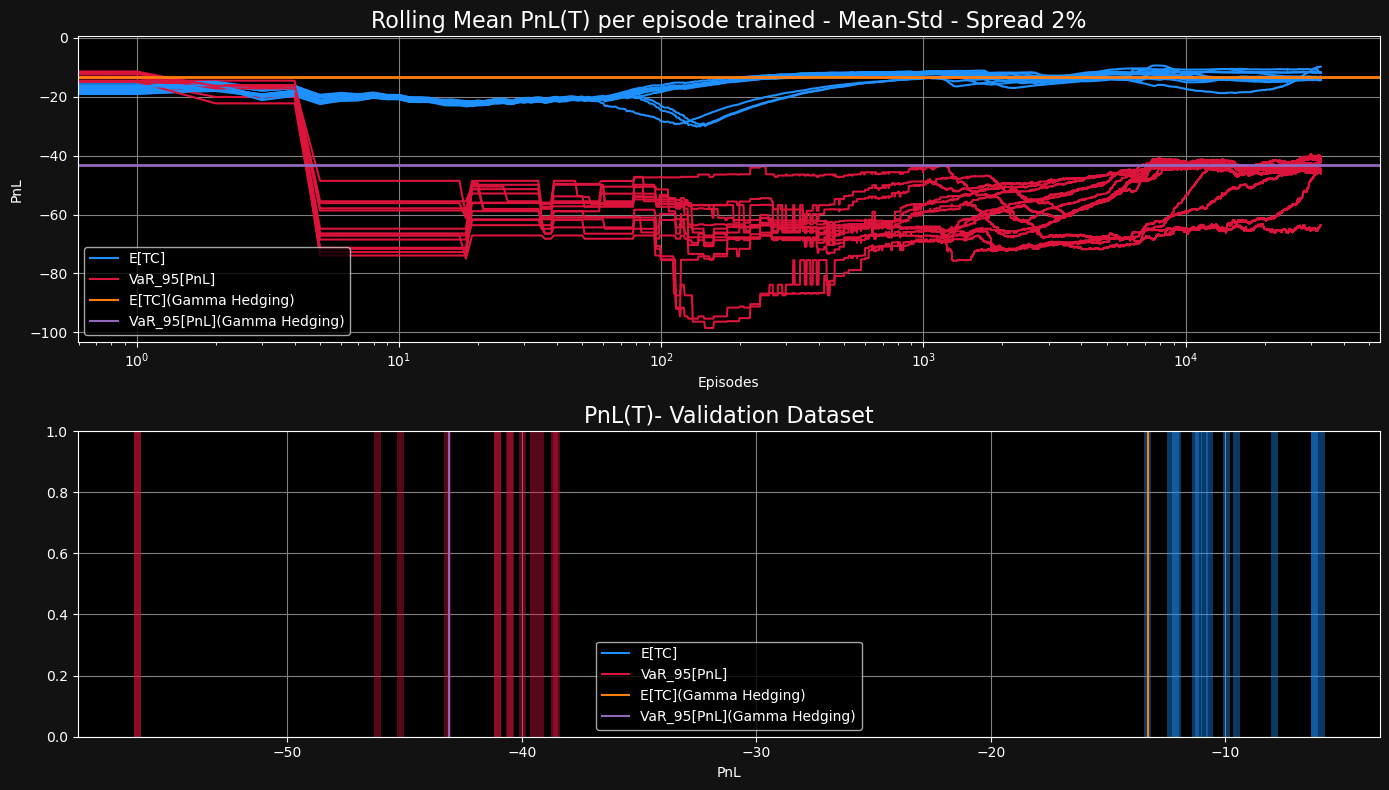

In [12]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_2/Heston_Mean_Std_Batch/'
N_E = 16
batch_template_train = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(2, N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 2% - VaR

Heston Mean-Std 0.5%:0 pnl mean: -8.42 (±1.14) | std: 37.04520   | Mean-SD: -69.36 | gamma-ratio: -0.04(-0.10/ 0.00) | vega-ratio:  0.14( 0.00/ 0.39)| var95:   -69.41 | cvar95:   -98.58 | E[TC]: -5.14 (±0.15)
Heston Mean-Std 0.5%:1 pnl mean: -3.54 (±1.08) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.44 | cvar95:   -77.58 | E[TC]: -6.22 (±0.15)
Heston Mean-Std 0.5%:2 pnl mean: -3.54 (±1.08) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.44 | cvar95:   -77.58 | E[TC]: -6.22 (±0.15)
Heston Mean-Std 0.5%:3 pnl mean: -10.54(±0.50) | std: 16.26864   | Mean-SD: -37.31 | gamma-ratio:  0.36( 0.03/ 0.68) | vega-ratio:  0.18( 0.06/ 0.27)| var95:   -37.99 | cvar95:   -50.31 | E[TC]: -10.86(±0.10)
Heston Mean-Std 0.5%:4 pnl mean: -3.54 (±1.08) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.

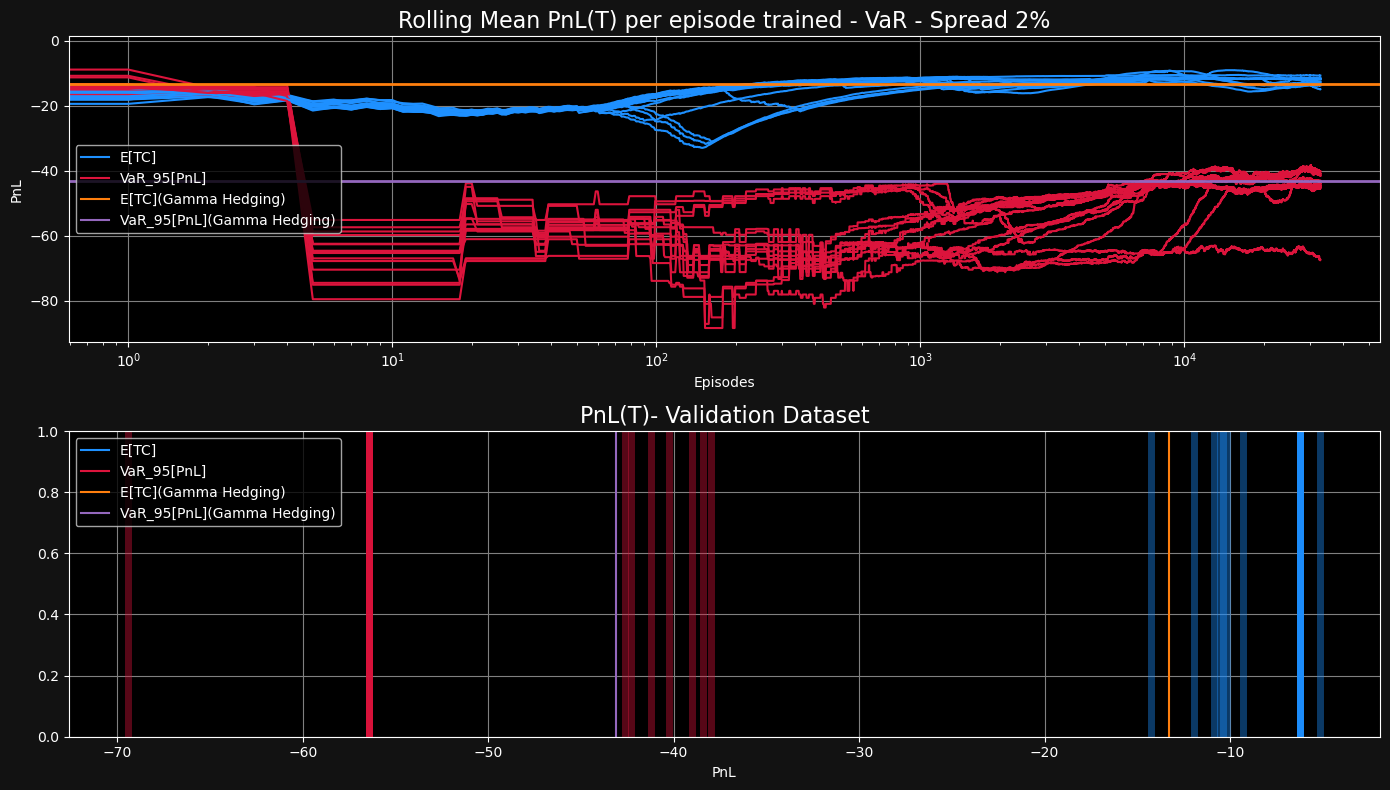

In [13]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_2/Heston_VaR_Batch/'
N_E = 16
batch_template_train = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 2% - CVaR

Heston Mean-Std 0.5%:0 pnl mean: -9.35 (±0.54) | std: 17.95803   | Mean-SD: -38.89 | gamma-ratio:  0.44( 0.28/ 0.59) | vega-ratio:  0.11( 0.04/ 0.19)| var95:   -39.59 | cvar95:   -53.17 | E[TC]: -9.28 (±0.11)
Heston Mean-Std 0.5%:1 pnl mean: -3.54 (±1.09) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.44 | cvar95:   -77.58 | E[TC]: -6.22 (±0.15)
Heston Mean-Std 0.5%:2 pnl mean: -3.54 (±1.09) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.44 | cvar95:   -77.58 | E[TC]: -6.22 (±0.15)
Heston Mean-Std 0.5%:3 pnl mean: -11.15(±0.55) | std: 18.19616   | Mean-SD: -41.08 | gamma-ratio:  0.24(-0.01/ 0.48) | vega-ratio:  0.22( 0.05/ 0.36)| var95:   -39.69 | cvar95:   -53.08 | E[TC]: -11.16(±0.11)
Heston Mean-Std 0.5%:4 pnl mean: -3.54 (±1.06) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.

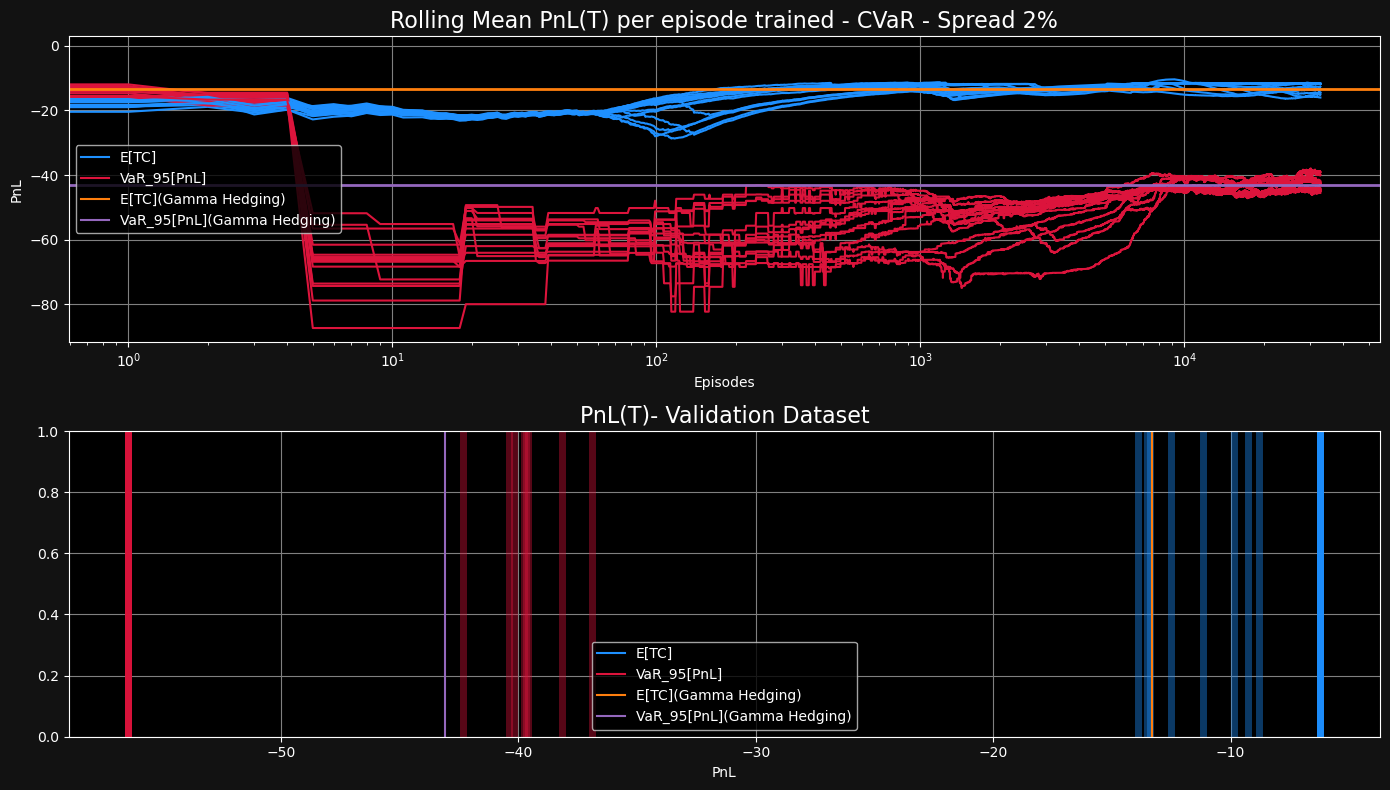

In [14]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_2/Heston_CVaR_Batch/'
N_E = 16
batch_template_train = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


---------------------------------
# Heston European hedging option - Single

## Srpead 0.5% - Mean-Std

i:4
logs/(EXP 2.2) Heston Experiments/spread_05/Heston_Mean_Std_Batch/Heston_Mean_Std_05_5/stochastic_process=Heston_spread=0.005_obj=meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv
Heston Mean-Std 0.5%:4 pnl mean: -0.30 (±0.01) | std: 0.52826    | Mean-SD: -1.17  | gamma-ratio:  0.76( 0.52/ 0.89) | vega-ratio:  0.79( 0.66/ 0.96)| var95:    -1.09 | cvar95:    -1.47 | E[TC]: -0.28 (±0.00)
i:5
logs/(EXP 2.2) Heston Experiments/spread_05/Heston_Mean_Std_Batch/Heston_Mean_Std_05_6/stochastic_process=Heston_spread=0.005_obj=meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv


NoDataError: empty CSV

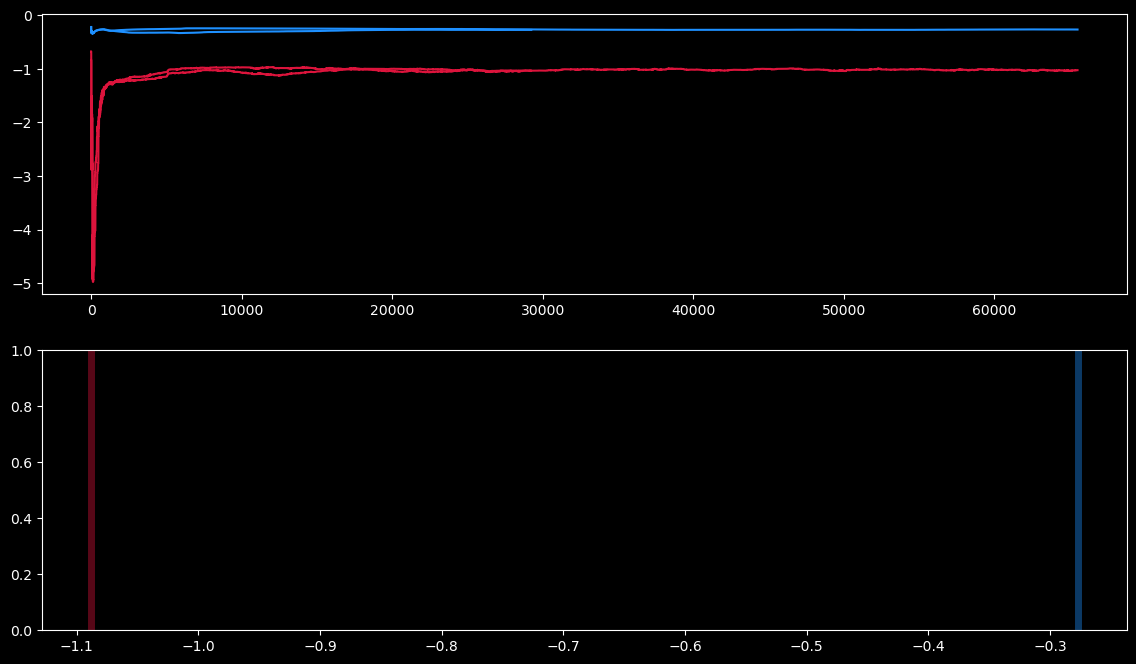

In [ ]:
base_path = 'logs/(EXP 2.2) Heston Experiments/spread_05/Heston_Mean_Std_Batch/'
N_E = 16
batch_template_train = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(4, N_E):    
    if i in [5, 13]: continue
    print(f'i:{i}')
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    print(batch_folders_eval[i])
    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()